# 0. Import des librairies

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import backend as K

# 1. Configuration GPU

In [42]:
# Configurer TensorFlow pour utiliser le GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


# 2. Paramétrage

In [43]:
# Nettoyage de la mémoire (au cas où :D)
K.clear_session()

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
CWD = Path.cwd()
NEW_TRAIN = CWD / "sorted_data" / "train"
NEW_VAL = CWD / "sorted_data" / "val"
NEW_TEST = CWD / "sorted_data" / "test"
class_names = {0: 'NORMAL', 1: 'VIRUS', 2: 'BACTERIA'}

# 3. Chargement des Datasets prétraités.

In [44]:
# Utiliser image_dataset_from_directory pour charger les datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=NEW_TRAIN,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=NEW_VAL,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=NEW_TEST,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Appliquer le prétraitement spécifique à VGG16
def preprocess(image, label):
    return preprocess_input(image), label

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 12484 files belonging to 3 classes.
Found 288 files belonging to 3 classes.
Found 822 files belonging to 3 classes.


# 4. Le modèle

In [45]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten(name='new_flatten')(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
classifieur = Dense(3, activation='softmax')(x)  # 3 classes: NORMAL, BACTERIA, VIRUS

new_model = Model(inputs=base_model.input, outputs=classifieur)

# 5. Gestion des Couches du VGG : Feature Extractor

In [46]:
# Geler les couches de base
for layer in base_model.layers:
    layer.trainable = False

# 6. Compilation et Hyperparamètres

In [47]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,206,083 (80.89 MB)

 Trainable params: 6,490,371 (24.76 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [48]:
# Callbacks pour l'entraînement
es = EarlyStopping(
    monitor="val_accuracy", 
    mode="max", 
    patience=10,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

history = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS, 
    callbacks=[es, reduce_lr],
    shuffle=True
)

Epoch 1/30


2024-07-03 10:21:39.345114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:130: Filling up shuffle buffer (this may take a while): 386 of 1000
2024-07-03 10:21:39.401628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-07-03 10:21:39.401834: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268096 bytes after encountering the first element of size 19268096 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


391/391 ━━━━━━━━━━━━━━━━━━━━ 67s 136ms/step - accuracy: 0.6470 - loss: 1.7351 - recall: 0.6298 - val_accuracy: 0.6944 - val_loss: 1.3735 - val_recall: 0.6806 - learning_rate: 1.0000e-04
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 50s 129ms/step - accuracy: 0.7686 - loss: 1.2853 - recall: 0.7577 - val_accuracy: 0.6840 - val_loss: 1.4122 - val_recall: 0.6701 - learning_rate: 1.0000e-04
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 50s 129ms/step - accuracy: 0.8111 - loss: 1.1331 - recall: 0.8005 - val_accuracy: 0.7535 - val_loss: 1.3125 - val_recall: 0.7465 - learning_rate: 1.0000e-04
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 50s 129ms/step - accuracy: 0.8496 - loss: 1.0125 - recall: 0.8415 - val_accuracy: 0.7083 - val_loss: 1.3183 - val_recall: 0.7014 - learning_rate: 1.0000e-04
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.8587 - loss: 0.9550 - recall: 0.8518 - val_accuracy: 0.7118 - val_loss: 1.3396 - val_recall: 0.7049 - learning_rate: 1.0000e-04
Epoch 6/30
391/391 ━━━━━━━

# 7. Tests du modèle sur dataset Test

In [49]:
test_loss, test_accuracy, test_recall = new_model.evaluate(test_dataset)
print(f"Loss on test dataset: {test_loss}")
print(f"Accuracy on test dataset: {test_accuracy}")
print(f"Recall on test dataset: {test_recall}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.8584 - loss: 1.1143 - recall: 0.8549
Loss on test dataset: 1.3395755290985107
Accuracy on test dataset: 0.7834550142288208
Recall on test dataset: 0.7785888314247131


# 8. Sauvegarde du modèle pour utilisation ultérieure

In [50]:
new_model.save('1_modele_final_feature_extractor.keras')

# 9. Comparaison Training et Test

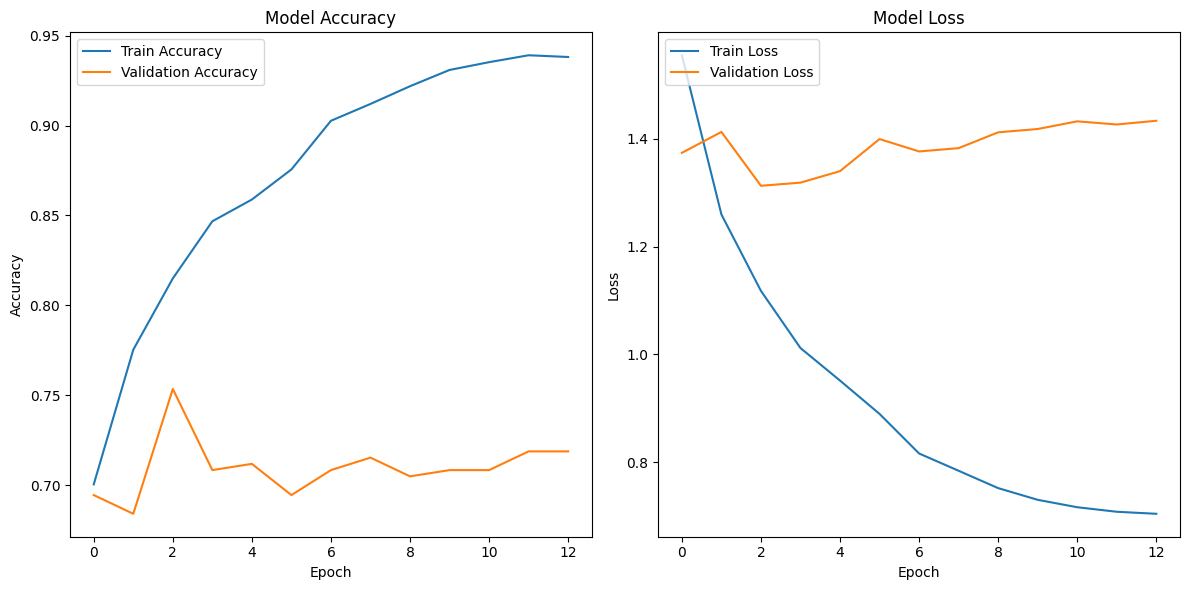

In [51]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# 10. Prédictions / Matrice de confusion / Heatmap

2024-07-03 10:32:39.529562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step


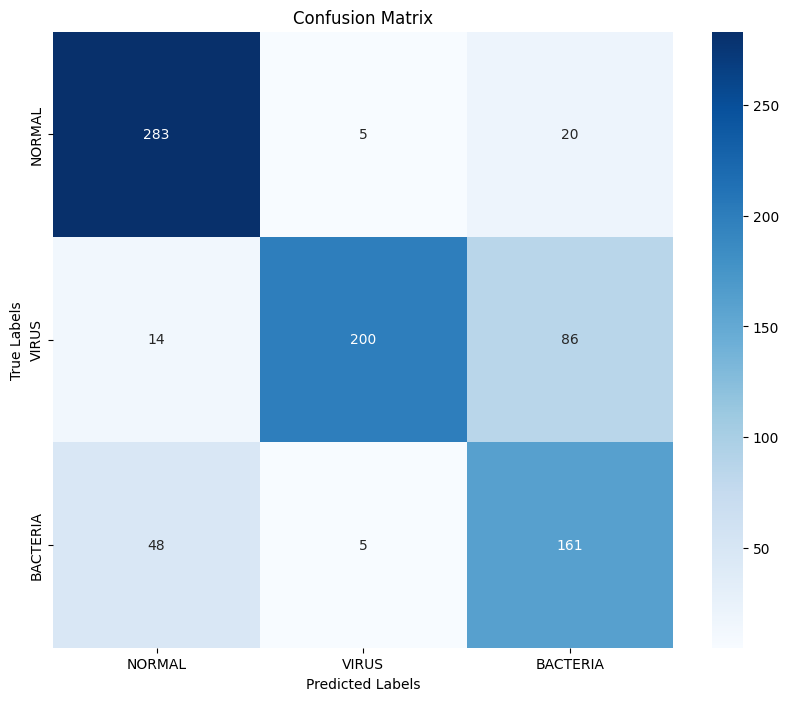

In [52]:
# Prédire les classes sur le jeu de test
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = new_model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(true_labels, predicted_labels)

# Tracer la heatmap de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()